# Assignment 2. Language modeling.

This task is devoted to language modeling. Its goal is to write in PyTorch an RNN-based language model. Since word-based language modeling requires long training and is memory-consuming due to large vocabulary, we start with character-based language modeling. We are going to train the model to generate words as sequence of characters. During training we teach it to predict characters of the words in the training set.



## Task 1. Character-based language modeling: data preparation (15 points).

We train the language models on the materials of **Sigmorphon 2018 Shared Task**. First, download the Russian datasets.

In [114]:
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

--2020-03-31 18:10:18--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 533309 (521K) [text/plain]
Saving to: ‘russian-train-high.1’

russian-train-high. 100%[===================>] 520.81K  --.-KB/s    in 0.05s   

2020-03-31 18:10:18 (9.33 MB/s) - ‘russian-train-high.1’ saved [533309/533309]

--2020-03-31 18:10:19--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


**1.1 (1 points)**
All the files contain tab-separated triples ```<lemma>-<form>-<tags>```, where ```<form>``` may contain spaces (*будете соответствовать*). Write a function that loads a list of all word forms, that do not contain spaces.  

In [115]:
def read_infile(infile):

    words = []
    with open(infile) as file:
        for line in file:
            form_word = line.split('\t')[1]
            if ' ' not in form_word:
                words.append(form_word.lower())
    return words

In [116]:
train_words = read_infile("russian-train-high")
dev_words = read_infile("russian-dev")
test_words = read_infile("russian-test")
print(len(train_words), len(dev_words), len(test_words))
print(*train_words[:10])

9213 917 922
валлонскому незаконченным истрёпывав личного серьгам необоснованным тюти заросла идеальна гулкой


**1.2 (2 points)** Write a **Vocabulary** class that allows to transform symbols into their indexes. The class should have the method ```__call__``` that applies this transformation to sequences of symbols and batches of sequences as well. You can also use [SimpleVocabulary](https://github.com/deepmipt/DeepPavlov/blob/c10b079b972493220c82a643d47d718d5358c7f4/deeppavlov/core/data/simple_vocab.py#L31) from DeepPavlov. Fit an instance of this class on the training data.

In [117]:
 !pip install deeppavlov

In [118]:
from deeppavlov.core.data.simple_vocab import SimpleVocabulary

vocab = SimpleVocabulary(save_path=False)
train_words_with_symbols = [['<PAD>', '<BEGIN>', '<END>']]
train_words_with_symbols += train_words
vocab.fit([list(x) for x in train_words_with_symbols])
print(len(vocab))

2020-03-31 18:10:28.266 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 52: No load path is set for SimpleVocabulary!


37


In [119]:
PAD_key = vocab('<PAD>')
BEGIN_key = vocab('<BEGIN>')
END_key = vocab('<END>')

**1.3 (2 points)** Write a **Dataset** class, which should be inherited from ```torch.utils.data.Dataset```. It should take a list of words and the ```vocab``` as initialization arguments.

In [120]:
import torch
from torch.utils.data import Dataset as TorchDataset

class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __getitem__(self, index):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.        
        """
        assert index < len(self)
        word = self.data[index]
        
        source = []
        target = []
        source.append(BEGIN_key)
        for letter in word:
            source.append(vocab._t2i[letter])
            target.append(vocab._t2i[letter])
        target.append(END_key)
        
        source = torch.tensor(source)
        target = torch.tensor(target)
        return torch.stack([source, target])

    def __len__(self):
        return len(self.data)

In [121]:
train_dataset = Dataset(train_words, vocab)
dev_dataset = Dataset(dev_words, vocab)
test_dataset = Dataset(test_words, vocab)

Let's check whether it words correctly or not:

In [122]:
j = 6
source = train_dataset[j][0]
word = []
for i in source:
    word.append(vocab[i.item()])
print(f'Actual word: {train_words[j]}; Source: {word}')

Actual word: тюти; Source: ['<BEGIN>', 'т', 'ю', 'т', 'и']


**1.4 (3 points)** Use a standard ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with ```batch_size=1```.

In [123]:
from torch.utils.data import DataLoader

batcher = DataLoader(train_dataset, batch_size=1, num_workers=5)
i = 0
for batch in batcher:
    print(batch.shape)
    i += 1
    if i == 10:
        break

torch.Size([1, 2, 12])
torch.Size([1, 2, 14])
torch.Size([1, 2, 11])
torch.Size([1, 2, 8])
torch.Size([1, 2, 8])
torch.Size([1, 2, 15])
torch.Size([1, 2, 5])
torch.Size([1, 2, 8])
torch.Size([1, 2, 9])
torch.Size([1, 2, 7])


**(1.5) 1 point** Explain, why this does not work with larger batch size.

**(1.6) 5 points** Write a function **collate** that allows you to deal with batches of greater size. See [discussion](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8) for an example. Implement your function as a class ```__call__``` method to make it more flexible.

In [124]:
def pad_tensor(vec, length, dim, pad_symbol):
    """
    Pads a vector ``vec`` up to length ``length`` along axis ``dim`` with pad symbol ``pad_symbol``.
    """
    pad_size = list(vec.shape)
    pad_size[dim] = length - vec.size(dim)
    padding = torch.ones(*pad_size) * pad_symbol
    padding = padding.type(torch.LongTensor)
    return torch.cat([vec, padding], dim=dim)


class Padder:
    def __init__(self, dim=0, pad_symbol=PAD_key):
        self.dim = dim
        self.pad_symbol = pad_symbol
        
    def pad_collate(self, batch):
        # find longest sequence
        max_len = max(map(lambda x: x[0].shape[self.dim], batch))
        
        # pad according to max_len
        source = list(map(lambda x: pad_tensor(x[0], max_len, self.dim, self.pad_symbol), batch))
        target = list(map(lambda x: pad_tensor(x[1], max_len, self.dim, self.pad_symbol), batch))
        
        xs = torch.stack(source)
        ys = torch.stack(target)
        return xs, ys

    def __call__(self, batch):
        return self.pad_collate(batch)

**(1.7) 1 points** Again, use ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with the batch size you like.

In [125]:
from torch.utils.data import DataLoader

padder = Padder()

batcher = DataLoader(train_dataset, collate_fn=padder, batch_size=5)
i = 0
for batch in batcher:
    print(batch[0].shape)
    i += 1
    if i == 10:
        break

torch.Size([5, 14])
torch.Size([5, 15])
torch.Size([5, 15])
torch.Size([5, 14])
torch.Size([5, 12])
torch.Size([5, 16])
torch.Size([5, 18])
torch.Size([5, 14])
torch.Size([5, 16])
torch.Size([5, 13])


## Task 2. Character-based language modeling. (35 points)

**2.1 (5 points)** Write a network that performs language modeling. It should include three layers:
1. **Embedding** layer that transforms input symbols into vectors.
2. An **RNN** layer that outputs a sequence of hidden states (you may use https://pytorch.org/docs/stable/nn.html#gru).
3. A **Linear** layer with ``softmax`` activation that produces the output distribution for each symbol.

In [126]:
import torch.nn as nn

class RNNLM(nn.Module):

    def __init__(self, vocab_size, embeddings_dim, hidden_size, num_layers=1, dropout=0):
        super(RNNLM, self).__init__()
        self.embed = torch.nn.Embedding(vocab_size, embeddings_dim)
        self.rnn = torch.nn.GRU(embeddings_dim, hidden_size, num_layers=num_layers, batch_first=True)
        self.l1 = torch.nn.Linear(hidden_size, vocab_size)
        self.hidden = None
        
    def forward(self, inputs, hidden=None):
        x = self.embed(inputs)
        x, self.hidden = self.rnn(x, hidden)
        x = self.l1(x)
        return x

**2.2 (1 points)** Write a function ``validate_on_batch`` that takes as input a model, a batch of inputs and a batch of outputs, and the loss criterion, and outputs the loss tensor for the whole batch. This loss should not be normalized.

In [127]:
def validate_on_batch(model, criterion, x, y):
    scores = model(x)
    vocab_size = scores.shape[-1]
    return criterion(scores.reshape((-1, vocab_size)), y.reshape(-1))

**2.3 (1 points)** Write a function ``train_on_batch`` that accepts all the arguments of ``validate_on_batch`` and also an optimizer, calculates loss and makes a single step of gradient optimization. This function should call ``validate_on_batch`` inside.

In [128]:
def train_on_batch(model, criterion, x, y, optimizer):
    optimizer.zero_grad()
    loss = validate_on_batch(model, criterion, x, y)
    loss.backward()
    optimizer.step()
    return loss

**2.4 (3 points)** Write a training loop. You should define your ``RNNLM`` model, the criterion, the optimizer and the hyperparameters (number of epochs and batch size). Then train the model for a required number of epochs. On each epoch evaluate the average training loss and the average loss on the validation set. 

**2.5 (3 points)** Do not forget to average your loss over only non-padding symbols, otherwise it will be too optimistic.

In [129]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

sns.set_style('darkgrid')

In [130]:
USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [131]:
vocab_size = len(vocab)
embeddings_dim = 20
hidden_size = 50

model = RNNLM(vocab_size, embeddings_dim, hidden_size)

def train(model, epochs=300, batch_size=80, epoch_response=50, draw_loss=True):
    '''
    epochs: number of epochs
    batch_size: size of one batch
    epoch_response: how frequently print epoch duration time. 1 - print each epoch
    draw_loss: whether or not draw loss plot
    
    '''
    model = model.to(device=device, dtype=dtype)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_key)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    padder = Padder()
    batcher = DataLoader(train_dataset, collate_fn=padder, batch_size=batch_size, shuffle=True)
    
    print(f'Train starts with parametres:')
    print(f'Batch size:{batch_size}')
    print(f'Epoch number:{epochs} \n')
    
    losses = []
    for e in range(1, epochs+1):
        
        if e % epoch_response == 0:
            print(f'{e} epoch started...')
        loss_per_epoch = []
        
        start = time.time()
        for i, (X, y) in enumerate(batcher):
            X = X.to(device=device, dtype=torch.long)
            y = y.to(device=device, dtype=torch.long)
            
            loss = train_on_batch(model, criterion, X, y, optimizer)
            loss_per_epoch.append(loss.item())
        end = time.time()
        
        if e % epoch_response == 0:
            print(f'{e} epoch run for {np.round(end - start, 1)} sec')
            
        loss_per_epoch = np.array(loss_per_epoch)
        losses.append(loss_per_epoch.mean())
        
    if draw_loss:
        plt.figure(figsize=(16, 9))
        plt.plot(np.arange(epochs), losses)
        plt.title('Loss per epoch')
        plt.xlabel('epoch number')
        plt.ylabel('loss')

Train starts with parametres:
Batch size:80
Epoch number:200 

50 epoch started...
50 epoch run for 1.8 sec
100 epoch started...
100 epoch run for 1.3 sec
150 epoch started...
150 epoch run for 1.3 sec
200 epoch started...
200 epoch run for 1.3 sec


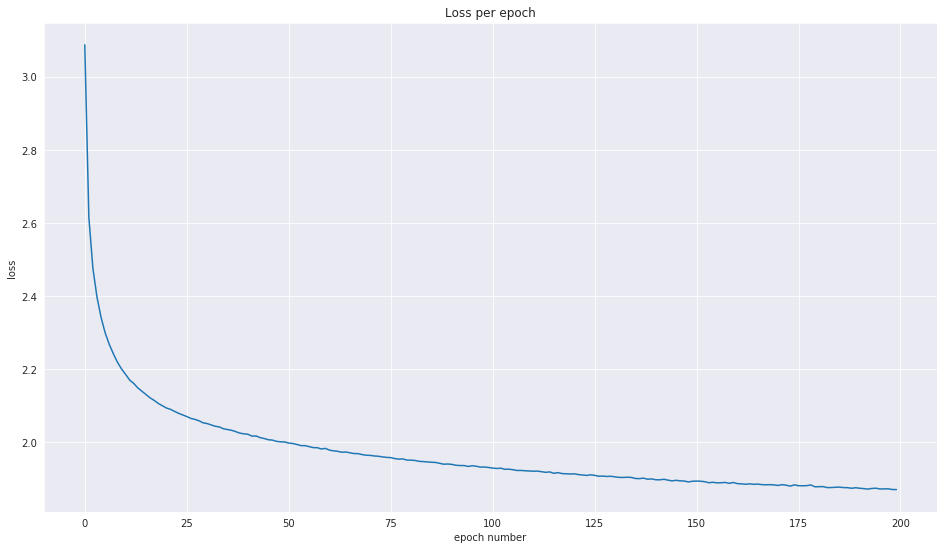

In [132]:
train(model, epochs=200)

**2.6 (5 points)** Write a function **predict_on_batch** that outputs letter probabilities of all words in the batch.

In [133]:
def predict_on_batch(model, batch):
    X = batch[0].to(device=device)
    y = batch[1]
    
    probs = F.softmax(model(X), dim=2)
    
    # лист буквенных вероятностей в словах
    words_in_batch_probs = []
    
    # лист слов с <END> на конце и без <PAD> символов
    words = []
    
    for j in range(y.shape[0]):
        letters_probs = []
        word = []
        for i in range(0, y.shape[1]):
            # получаем вероятности буквы
            letters_probs.append(probs[j, i, y[j, i].item()].item())
            
            # получаем номер буквы в словаре
            word.append(y[j, i].item())
            
            # если это последний символ, прекращаем обработку
            if (i == y.shape[1]-1):
                break
                
            # если следующий символ это <PAD>, прекращаем обработку
            if  (y[j, i+1].item() == PAD_key):
                break
            
        words_in_batch_probs.append(letters_probs)
        words.append(word)
    return words_in_batch_probs, words

**2.7 (1 points)** Calculate the letter probabilities for all words in the test dataset. Print them for 20 last words. Do not forget to disable shuffling in the ``DataLoader``.

In [134]:
len(test_dataset)

922

In [135]:
padder = Padder()
model = model.to(device=device)
batcher = DataLoader(test_dataset, num_workers=5, collate_fn=padder, batch_size=1, shuffle=False)
words_probs = []
words = []
for batch in batcher:
    probs_, words_ = predict_on_batch(model, batch)
    words_probs.extend(probs_)
    words.extend(words_)

In [136]:
len(words_probs)

922

In [137]:
for i in range(20, 0, -1):
    for j in range(len(words_probs[-i])):
        print(f'{vocab(words[-i][j])} - {words_probs[-i][j]}')
    print('\n')

п - 0.1510084718465805
ш - 0.0002178774302592501
е - 0.435866117477417
н - 0.1354728788137436
и - 0.10382778197526932
ч - 0.10170184820890427
н - 0.34817954897880554
о - 0.37517407536506653
й - 0.450470894575119
<END> - 0.9998168349266052


п - 0.1510084718465805
е - 0.12407582253217697
р - 0.7711210250854492
е - 0.8612046837806702
ж - 0.017555205151438713
и - 0.41034775972366333
в - 0.06521474570035934
а - 0.5470951795578003
н - 0.008480402640998363
и - 0.37007877230644226
я - 0.2865845263004303
м - 0.1624041348695755
и - 0.543552815914154
<END> - 0.9982739686965942


н - 0.05835745111107826
а - 0.345723420381546
и - 0.014208868145942688
б - 0.06119542941451073
о - 0.12441470474004745
л - 0.07363860309123993
ь - 0.28683778643608093
ш - 0.0053826263174414635
и - 0.5992121696472168
м - 0.5755752325057983
<END> - 0.744979739189148


п - 0.1510084718465805
р - 0.3733057379722595
а - 0.05107372626662254
в - 0.350699782371521
и - 0.2723378539085388
т - 0.09665608406066895
е - 0.115954436361

**2.8 (5 points)** Write a function that generates a single word (sequence of indexes) given the model. Do not forget about the hidden state! Be careful about start and end symbol indexes. Use ``torch.multinomial`` for sampling.

In [138]:
def generate(model, max_length=20, start_index=1, end_index=2):
    model.hidden = None
    last_letter = torch.tensor(start_index).reshape((1, 1))
    last_letter = last_letter.to(device=device)
    new_word = vocab(start_index)
    index = start_index
    
    while (index != end_index) and (len(new_word) < max_length):
        probs = F.softmax(model(last_letter, model.hidden), dim=2)
        index = torch.multinomial(probs[0, -1], 1)
        new_word += vocab(index.item())
        last_letter = torch.tensor(index).reshape((1, 1))
        last_letter = last_letter.to(device=device)
        
    return new_word

**2.9 (1 points)** Use ``generate`` to sample 20 pseudowords. Do not forget to transform indexes to letters.

In [139]:
for i in range(20):
    print(generate(model, start_index = BEGIN_key, end_index=END_key).replace('<BEGIN>','').replace('<END>', ''))

куехоалы
примопанов
гружинистки
дочучкам
плахать
занамах
хогельетя
пегита
сператившийся
походных
произменедним
отцидким
браниями
мароветникога
приадировали
ковскогов
геретических
союриномных
рмянзулков
абпавивай


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


**(2.10) 5 points** Write a batched version of the generation function. You should sample the following symbol only for the words that are not finished yet, so apply a boolean mask to trace active words.

In [140]:
def generate_batch(model, batch_size, max_length = 20, start_index=1, end_index=2):
    model.hidden = None
    indices = torch.ones((batch_size, 1)) * start_index
    indices = indices.to(device=device, dtype=torch.long)
    new_words = [vocab(start_index) for i in range(batch_size)]
    
    done_mask = torch.zeros(batch_size, dtype=torch.bool)
    done_mask = done_mask.to(device=device)
    count_letters = 1
    
    while not done_mask.all() and count_letters < max_length:
        probs = F.softmax(model(indices, model.hidden), dim=2)
        indices = torch.multinomial(probs.reshape((batch_size, -1)), 1)
        new_letters = ['' + vocab(indices[i].item()) * ~done_mask[i] for i in range(batch_size)]
        new_words = [word + letter for word, letter in zip(new_words, new_letters) ]
        done_mask = done_mask | (indices.reshape(-1) == end_index)
        count_letters += 1
        
    return new_words

In [141]:
generated = []
for _ in range(2):
    generated.extend(generate_batch(model, batch_size=10, start_index=BEGIN_key, end_index=END_key))
    transformed = [word.replace('<BEGIN>','').replace('<END>', '') for word in generated]
    
for elem in transformed:
    print(elem)

аребам
плесинами
иннегонов
манекцами
стесанциваривайте
устовоонами
незиумивников
видам
сеше
пришекает
астроматром
тюрафиках
абаял
жвициовались
мостным
разветном
зельту
несбейноку
агострой
карторинке


**(2.11) 5 points** Experiment with the type of RNN, number of layers, units and/or dropout to improve the perplexity of the model.

Train starts with parametres:
Batch size:80
Epoch number:200 

50 epoch started...
50 epoch run for 1.9 sec
100 epoch started...
100 epoch run for 2.0 sec
150 epoch started...
150 epoch run for 2.0 sec
200 epoch started...
200 epoch run for 2.0 sec


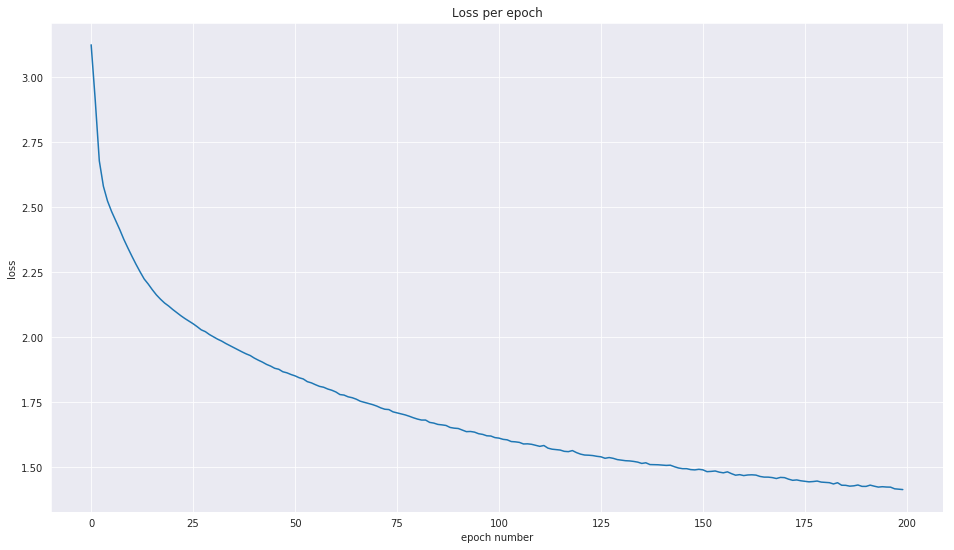

In [143]:
vocab_size = len(vocab)
embeddings_dim = 20
hidden_size = 50

model = RNNLM(vocab_size, embeddings_dim, hidden_size, num_layers=5, dropout=0.3)

train(model, epochs=200, batch_size=200)

In [144]:
for i in range(20):
    print(generate(model, start_index = BEGIN_key, end_index=END_key).replace('<BEGIN>','').replace('<END>', ''))

веёдствись
ассокренаешь
микримолы
горным
расстреловым
литавься
скупа
подвануло
бедоканизмого
таммолок
лине
абричка
сбедченны
водоворов
пакта
выданиям
искрят
быряником
проругон
сервного


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
